# Introduction to atomman: Dislocation solution and generator

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction<a id='section1'></a>

This Notebook outlines the use of the classes and methods in atomman for obtaining elastic solutions for perfectly straight dislocations and constructing atomic configurations based on them.  

- [Section #2](#section2) details the theory used to obtain the dislocation solutions and construct the atomic systems.
- [Section #3](#section3) describes the VolterraDislocation classes that provide the elastic dislocation solutions and the various properties that can be obtained from them.  This is useful if you want a dislocation solution but don't want to construct an atomic configuration.
- [Section #4](#section4) introduces the Dislocation class that provides a convenient means of constructing atomic configurations of dislocations.
- [Section #5](#section5) shows how the Dislocation class can be used to generate dislocation monopole configurations.
- [Section #6](#section6) shows how the Dislocation class can be used to generate periodic array of dislocations configurations.

In [1]:
# Standard Python libraries
import os
import datetime

# http://www.numpy.org/
import numpy as np

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# https://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today()) 

atomman version = 1.4.4
Notebook executed on 2022-03-17


## 2. Theory<a id='section2'></a>

The Dislocation class is meant to provide a simple and convenient means of generating dislocation monopole and periodic array of dislocations atomic configurations.  The dislocation configurations generated by this class contain a single dislocation which is inserted into an otherwise perfect crystalline system by applying displacements corresponding to a Volterra dislocation solution.  The boundary conditions are then handled differently based on whether the system is to be a dislocation monopole configuration or a periodic array of dislocations configuration.

### 2.1. Dislocation solutions

Dislocation theory is based on computing and using elasticity solutions of dislocations to define what they look like and how they interact with the surrounding material. The Volterra dislocation model assumes that the discontinuity in the crystal due to the dislocation exists as a line singularity. While this assumption does not hold true in real materials, the Volterra solution still provides a decent guess for the long-range stress and strain fields of compact dislocation cores. It also provides a useful starting point for developing more complicated dislocation solutions, and can provide good initial guesses for constructing atomic dislocation configurations.

Solutions of straight dislocations are always defined relative to three orthogonal unit vectors $\hat{m}$, $\hat{n}$, and $\hat{\xi}$

- $\hat{m}$ is the direction in the slip plane perpendicular to the dislocation's line direction.
- $\hat{n}$ is the normal of the dislocation's slip plane.
- $\hat{\xi}$ is parallel to the dislocation's line direction.

Based on these three vectors, we can define a Cartesian coordinate system for the dislocation solution with positions, $x_i$, given by

$$ x_i = x_1 \hat{m} + x_2 \hat{n} + x_3 \hat{\xi} $$

For straight dislocations, the elasticity solutions are independent of the $x_3$ direction and therefore only depend on $x_1$ and $x_2$.

#### 2.1.1. Isotropic solution

For isotropic materials, the elastic solution for a Volterra dislocation can be given as analytical equations.  Variations of the analytical solutions can be found in every textbook on dislocation theory.  The particular equations used in atomman match those found in Elementary Dislocation Theory by Weertman and Weertman except with flipped signs.  This choice provides the best correspondence of the isotropic solution to the anisotropic solutions described below.

Isotropic elastic constants can be represented using only two independent terms. The two isotropic elastic constants typically used for dislocation solutions are the shear modulus, $\mu$, and the Poisson's ratio, $\nu$.

The isotropic displacements, $d_i$, for a dislocation centered at $x_1 = x_2 = 0$ are

$$ u_1 = \frac{b_1}{2 \pi} \left[ \theta + \frac{x_1x_2}{2 (1 - \nu) (x_1^2 + x_2^2)} \right]$$

$$ u_2 = \frac{b_1}{2 \pi} \left[ -\frac{1 - 2 \nu} {4 (1 - \nu)} \ln(x_1^2 + x_2^2)
                           + \frac{y^2} {2 (1 - \nu) (x^2 + y^2)} \right]$$

$$ u_3 = \frac{b_3}{2 \pi} \theta.$$

Here (and below), $\theta$ is the radial angle coordinate

$$\theta=\tan^{-1} (x_2/x_1),$$

which is taken to range from $-\pi$ to $\pi$.

The isotropic stress, $\sigma_{ij}$, is given by the equations

$$ \sigma_{11} = -\frac{\mu b_1}{2 \pi (1 - \nu)} \frac{x_2 (3 x_1^2 + x_2^2)} { (x_1^2 + x_2^2)^2}$$

$$ \sigma_{22} = \frac{\mu b_1}{2 \pi (1 - \nu)} \frac{x_2 (x_1^2 - x_2^2)} { (x_1^2 + x_2^2)^2}$$

$$ \sigma_{33} = \nu(\sigma_{11} + \sigma_{22})$$

$$ \sigma_{12} = \frac{\mu b_1}{2 \pi (1 - \nu)} \frac{x_1(x_1^2 - x_2^2)) }{ (x_1^2 + x_2^2)^2}$$

$$ \sigma_{13} =-\frac{\mu b_3}{2 \pi} \frac{x_2}{(x_1^2 + x_2^2)} $$

$$ \sigma_{23} = \frac{\mu b_3}{2 \pi} \frac{x_1}{(x_1^2 + x_2^2)} $$

The energy coefficient tensor, $K_{ij}$, depends on the elastic constants.  Only normal components are non-zero for the isotropic case

$$K_{11}^{iso} = K_{22}^{iso} = K_{edge}^{iso} = \frac{\mu}{1 - \nu}$$
$$K_{33}^{iso} = K_{screw}^{iso} = \mu.$$

__Caution__: $K_{ij}$ may be defined slightly differently in other works depending on if they contain multiplicative factors.  If you are comparing atomman's values to other works, be sure to double check how $K_{ij}$ and the self-energy equations below are defined.

The dislocation's self-energy is the energy per unit length within a ring region around the dislocation line.  It depends on $K_{ij}$ and $b_i$

$$\frac{W}{l} = \frac{b_i K_{ij} b_j}{4 \pi} \ln{ \left( \frac{R}{r_0} \right)}.$$

The energy coefficient tensor can also be reduced down to a single coefficient, $K$

$$ K = \frac{b_i K_{ij} b_j} {b_k b_k},$$

which the self-energy expression then becomes

$$\frac{W}{l} = \frac{K b^2}{4 \pi} \ln{ \left( \frac{R}{r_0} \right)}, $$

Alternatively, everything in the self-energy expression outside the ln term can be grouped together as the pre-ln factor

$$\frac{W}{l} = a \ln{ \left( \frac{R}{r_0} \right)}. $$

#### 2.1.2. Anisotropic solution

The elasticity solution for Volterra dislocations in anisotropic materials was first introduced by [Eshelby](https://doi.org/10.1016/0001-6160(53)90099-6). Starting with the fundamental equations of elasticity

$$ \sigma_{ij} = C_{ijkl} \epsilon_{kl} $$

$$ \epsilon_{ij} = \frac{1}{2} \left(\frac{\partial u_i}{\partial x_j} + \frac{\partial u_j}{\partial x_i}\right) $$

$$ \frac{\partial \sigma_{ij}}{\partial x_j} = 0 $$

Combining these and taking the solution to be independent of $x_3$ generates the partial differential equation

$$ C_{ijkl} \frac{ \partial^2 u_k}{\partial x_j \partial x_l} = 0 $$

Solutions of the partial differential equation are of the form

$$ u_k = A_k f(x_1 + p x_2) $$

Values of $A_k$ and $p$ can be found by solving

$$ \left[C_{i1k1} + \left(C_{i1k2} + C_{i2k1} \right) p + C_{i2k2} p^2 \right] A_k = 0 $$

The determinate expression is a sixth-order polynomial expression resulting in six complex roots, $p_\alpha$ with $\alpha$ ranging 1 to 6. There is also one $A_{k \alpha}$ corresponding to each root.

Later, [Stroh](https://doi.org/10.1080/14786435808565804) introduced a method for easily solving for the six roots.  Another vector, $L_i$ is defined for each $\alpha$ root as

$$ L_{i \alpha} = \left(C_{i2k1} + p_{\alpha} C_{i2k2} \right) A_{k \alpha} $$

and a normalization factor, $k_{\alpha}$, is introduced as

$$ k_{\alpha} = \frac{1}{2 A_{j \alpha} L_{j \alpha}} $$

Stroh's method then expresses the problem as an eigenvector problem in which the eigenvalues give $p_{\alpha}$ and the eigenvectors give $A_{i \alpha}$ and $L_{i \alpha}$.  Properties of the dislocation can then be computed using these solution parameters

$$ u_j = \frac{1}{2 \pi i} \sum_{\alpha}  \pm k_{\alpha} A_{j \alpha} (L_{l \alpha} b_l) \ln{\eta_{\alpha}}$$

$$ \sigma_{ij} = \frac{1}{2 \pi i} \sum_{\alpha}  \pm k_{\alpha} C_{ijkl}[m_l + p_{\alpha} n_l] A_{k \alpha} (L_{m \alpha} b_m) \frac{1}{\eta_{\alpha}} $$

$$ K_{jl} = i \sum_{\alpha} \pm k_{\alpha} L_{j \alpha} L_{l \alpha} $$

For the displacement and stress equations, $\eta$ is an imaginary coordinate  that combines $x_1$ and $x_2$ using the computed eigenvalues $p_{\alpha}$

$$ \eta_{\alpha} = x_1 + p_{\alpha} x_2 $$

#### 2.1.3. Linear displacement solution

The periodic array of dislocations configuration uses an additional solution based on applying a linear gradient of displacements to the atoms to generate a geometrically necessary dislocation inside the system.

$$u_j = \frac{b_j}{2} - \text{sign}(x_2)\left[ \frac{x_1 b_j}{2l} + \frac{b_j}{4}\right],$$

where $l$ is the full periodic length of the system in the $\hat{m}$ direction. By applying opposite displacements above and below the slip plane, the atomic disregistry linearly varies from 0 to $b$ across the system.

While this does not give a good approximation of a real dislocation, it does have a couple of benefits besides its simplicity.  First, the solution is independent of the dislocation's position along the slip plane.  This makes it a good choice of displacements for the non-periodic surfaces if the atoms are held rigidly as the interaction between the dislocation and the boundaries will remain constant as the dislocation moves.  Also, since $u_j$ depends on $\text{sign}(x_2)$ rather than $x_2$ the solution on each side of the slip plane only depends on $x_1$.

### 2.2. Dislocation definition

A type of dislocation can be fully defined relative to a unit cell, ucell, by specifying the Miller slip plane, $n_{(hkl)}$, the Miller Burgers vector, $b_{[uvw]}$, and the Miller line direction, $\xi_{[uvw]}$.  Defining dislocations using Miller planes and vectors rather than Cartesian planes and vectors is more convenient as the definitions hold true for all crystals associated with a given crystal prototype. This is also how dislocations are typically defined by materials scientists.

The dislocation's character (screw, edge, mixed) is given by the angle between $b_{[uvw]}$ and $\xi_{[uvw]}$.  Screw dislocations have $\xi_{[uvw]}$ parallel to $b_{[uvw]}$, and therefore a character angle of 0$^{\circ}$ or 180$^{\circ}$, while edge dislocations have the two directions perpendicular for a character angle of 90$^{\circ}$.  For atomic configurations, the line direction must be a crystal vector, which limits the character angles that can be explored.  This is done as the system is periodic along the line direction vector and atomic compatibility is only possible if the direction is a lattice vector or a multiple of one.

The orientation of the dislocation solution with respect to the final atomic configuration is handled by specifying the dislocation solution axes $\hat{m}$ and $\hat{n}$ as Cartesian unit vectors.  For simplicity, the Dislocation class restricts $\hat{m}$, $\hat{n}$, and $\hat{\xi} = \hat{m} \times \hat{n}$ to each be aligned with one of the three Cartesian axes of the atomic configuration.

The slip plane normal relative to the unit cell, $n_{ucell}$, is identified by converting $n_{(hkl)}$ into Cartesian units. Using $n_{ucell}$, three Miller crystal vectors are identified that determine how to rotate the unit cell

- $\xi_{[uvw]}$.
- An in-plane vector with $|u|,|v|,|w|$ values less than some maximum that is closest to perpendicular to $\xi_{[uvw]}$.
- An out-of-plane vector with $|u|,|v|,|w|$ values less than some maximum that is closest to being parallel to $n_{ucell}$.

These three vectors are used as the box rotation vectors, $a_{[uvw]}$, $b_{[uvw]}$, and $c_{[uvw]}$, for orienting the final configuration.  How the identified vectors are associated with the rotation vectors depends on the Cartesian axes that $\hat{m}$, $\hat{n}$ and $\hat{\xi}$ correspond to

- In the final configuration, $a_{[uvw]}$ has its primary component along the $x$-axis, $b_{[uvw]}$ along the $y$-axis, and $c_{[uvw]}$ along the $z$-axis.
- $\xi_{[uvw]}$ is positioned along the Cartesian axis specified by $\hat{\xi}$.  This alignment means that the associated rotation vector will only have a component along that Cartesian direction.  For example, if $\hat{\xi}=x$, then $a_{[uvw]}$ will only have an $x$ component.
- The identified out-of-plane vector will correspond to the box rotation vector with the primary component along the Cartesian axis specified by $\hat{n}$.
- The identified in-plane vector is taken as the final box rotation vector.  As this vector is necessarily normal to $\hat{n}$, it cannot have a component along the Cartesian axis associated with $\hat{n}$.

Note that the out-of-plane vector need not be parallel to the slip plane normal.  Rather, it simply needs to be the only box vector with a component in the $\hat{n}$ direction.  This is because the slip plane is defined by the cross product of $\xi_{[uvw]}$ and the identified in-plane vector, not the out-of-plane vector.

A rotated cell, rcell, is then created using ucell and the rotation vectors.  This rotated cell serves as the seed for constructing the larger atomic configurations in which the dislocation is inserted.  As rcell is constructed, the Cartesian transformation matrix, $T$, associated with transforming from the ucell orientation to the rcell orientation is also identified.  The unit cell and $T$ are then used to convert $b_{[uvw]}$ to the Cartesian $b$ vector.

Finally, a rigid body shift, $\delta$ is defined relative to rcell.  This is used to adjust the atomic positions such that the mathematical position of the dislocation line and/or slip plane can be properly placed relative to the atoms.  For dislocations defined relative to crystal prototypes, $\delta$ can be expressed in reduced coordinates relative to ucell.  Alternatively, rcell itself can be used to identify shifts normal to the slip plane that place the mathematical slip plane halfway between all atomic planes in rcell.  This allows for dislocations to be easily generated either from pre-defined parameters or based on optimum shift recommendations.

### 2.3. Boundary conditions

#### 2.3.1. Dislocation monopoles

A dislocation monopole is an atomic configuration that contains a single straight dislocation.

- The box direction parallel to the dislocation line is made periodic.  The other two box directions are non-periodic.
- A boundary region is defined that encompasses the atoms near the non-periodic boundaries.  This region is identified by changing the atype values of the atoms in those geometric regions.

The Dislocation class constructs the atomic configurations but leaves it up to users to define how to relax the system.  Typically, the atoms in the boundary region are held fixed while the remaining atoms near the core are relaxed using molecular dynamics steps and/or an energy or force minimization.  Relaxations can either be rigid boundary relaxations or flexible boundary relaxations depending on if the boundary atoms are adjusted during the relaxation process.

A rigid boundary relaxation is one in which the boundary atoms are never adjusted after the initial system construction.  As the atoms are held at a dislocation solution, the initial positions tend to be a decent guess for dislocations with compact cores.  However, a misfit force will arise at the interface between the boundary and non-boundary atoms that can influence the dislocation structure, energies and behavior.  The influence of the misfit force can be minimized by constructing large atomic configurations and keeping investigations to dislocations with compact cores that remain positioned near the center of the systems.

A flexible boundary relaxation is one in which the boundary atoms are subjected to an alternative relaxation method, such as the lattice Greens function.  This alternative relaxation method allows for the misfit forces at the interface between the boundary and non-boundary atoms to be reduced while preventing the atoms at the non-periodic box boundaries from forming free surfaces.  This method is preferred for expensive atomistic methods like DFT as it gives good structure predictions as long as the dislocation core itself remains in the non-boundary region.

#### 2.3.2. Periodic array of dislocations

A periodic array of dislocations atomic configuration is one in which the system itself only contains one dislocation, but the system's box boundary conditions are such that it represents an infinite array of equally spaced dislocations.

- The two box directions in the slip plane are made periodic while the out-of-plane box direction is non-periodic.
- The box dimensions are modified to ensure that the atoms remain compatible and coherent across the two periodic box directions.
- For dislocations with edge components, the atomic compatibility requires that a half-plane of atoms either be inserted or deleted.  This is handled here by shrinking the box dimensions and identifying the half-plane of atoms to delete as those that have nearly identical positions with other atoms in the shrunken system.
- A boundary region is identified at the non-periodic surface.  The atoms in the boundary region are identified by changing their atype values, and are given coordinates that correspond to the global linear displacements rather than the local dislocation displacements.

The choice of displacing the atoms in the boundary region by a linear gradient of displacements rather than the dislocation solution displacements is done as the linear gradient is independent of the dislocation's position.  There will be misfit forces at the interface between the boundary and non-boundary regions, but those forces will be (mostly) independent of the dislocation's position in the system.  The slip behavior of dislocations can therefore be studied by applying shear strains/stresses to the system by adding displacements/forces to the boundary atoms. Some examples:

- Quasistatic calculations in which energy/force relaxations are used after incremental displacements of the boundaries. This can be used to estimate the Peierls barrier, with good estimates requiring very small force relaxation tolerances and very small displacements at each iteration.
- Strain-controlled simulations in which a constant displacement rate is applied to the boundary atoms.  Simulations can either have rigid boundaries, in which the boundary atoms only move in the displacement direction, or free-surface boundaries, in which motion in the displacement direction is fixed but MD motions in perpendicular directions are allowed.
- Stress-controlled simulations in which a constant force is applied to the boundary atoms.  Simulations can either have rigid boundaries, in which the boundary is treated as a rigid block that the force acts on, or free-surface boundaries, in which the boundary atoms are subjected to MD steps but each has an extra constant force applied to it.


## 3. Volterra solutions<a id='section3'></a>

__Skip to [Section #4](#section4) if you want to construct atomic configurations!__

A Volterra dislocation solution can be obtained with the solve_volterra_dislocation() function.

*Update Version 1.3.2: ξ_uvw, slip_hkl, and box parameters added to make defining systems easier, especially for non-cubic crystals.  axes renamed to transform for clarity.*

Parameters

- **C** (*atomman.ElasticConstants*) The medium's elastic constants.
- **burgers** (*array-like object*) The dislocation's Burgers vector.
- **ξ_uvw** (*array-like object*) The Miller crystal vector associated with the dislocation's line direction.  Must be given with slip_hkl to identify the transformation matrix to use on C and burgers.
- **slip_hkl** (*array-like object*) The Miller plane indices associated with the dislocation's slip plane.  Must be given with slip_hkl to identify the transformation matrix to use on C and burgers.
- **transform** (*array-like object, optional*) A 3x3 set of orthogonal Cartesian vectors that define the transformation matrix to use on C and burgers to convert from the standard (unit cell) and dislocation orientations.  The 3 vectors will automatically be converted into unit vectors.  Using this is an alternative to using ξ_uvw and slip_hkl.
- **axes** (*array-like object, optional*) Same as transform.  Retained for backwards compatibility.
- **box** (*atomman.Box, optional*) The unit cell's box that crystal vectors are taken with respect to. If not given, will use a cubic box with a=1 meaning that burgers, ξ_uvw and slip_hkl will be interpreted as Cartesian vectors.
- **m** (*array-like object, optional*) The m Cartesian unit vector for the solution giving the $x_1$ direction.  m, n, and $\xi$ (dislocation line direction) should be right-hand orthogonal.  Default value is [1,0,0] (Cartesian x-axis).
- **n** (*array-like object, optional*) The n Cartesian unit vector for the solution giving the $x_2$ direction.  m, n, and $\xi$ (dislocation line direction) should be right-hand orthogonal.  Default value is [0,1,0] (Cartesian y-axis).
- **tol** (*float*) Tolerance parameter used to round off near-zero values.  Default value is 1e-8.

Returns

- (*atomman.defect.VolterraDislocation*) The dislocation solution.  This will be an atomman.defect.IsotropicVolterraDislocation object or an atomman.defect.Stroh object depending on if the elastic constants used are isotropic or anisotropic.  

### 3.1. Build solution

Specify materials properties, namely the unit cell box and the elastic constants.

In [2]:
# Rough values for fcc Cu

# Build box
a = uc.set_in_units(3.6, 'angstrom')
box = am.Box.cubic(a=a)

# Isotropic Cij values
#E = uc.set_in_units(130, 'GPa')
#Poisson = 0.34
#C = am.ElasticConstants(E=E, nu=Poisson)

# Anisotropic values for Cu
C11 = uc.set_in_units(169, 'GPa')
C12 = uc.set_in_units(122, 'GPa')
C44 = uc.set_in_units(75.4, 'GPa')
C = am.ElasticConstants(C11=C11, C12=C12, C44=C44)

print('Cij in GPa:')
print(uc.get_in_units(C.Cij, 'GPa'))

Cij in GPa:
[[169.  122.  122.    0.    0.    0. ]
 [122.  169.  122.    0.    0.    0. ]
 [122.  122.  169.    0.    0.    0. ]
 [  0.    0.    0.   75.4   0.    0. ]
 [  0.    0.    0.    0.   75.4   0. ]
 [  0.    0.    0.    0.    0.   75.4]]


Specify the dislocation type.  Using box (above) allows for these values to be given as Miller crystal vectors.

In [3]:
# fcc a/2[1 0 -1](1 1 1)
burgers = 0.5 * np.array([1, 0, -1])
slip_hkl = np.array([1, 1, 1])

# The dislocation's line direction (ξ_uvw) determines character
ξ_uvw = [ 1,-2, 1] # 90 degree edge
#ξ_uvw = [1, -1, 0] # 60 degree mixed
#ξ_uvw = [1, 1, -2] # 30 degree mixed
#ξ_uvw = [1, 0, -1] # 0 degree screw, i.e. parallel to burgers

Specify the orientation for the solution.

In [4]:
m = [1, 0, 0] # align edge component with the x-axis
n = [0, 1, 0] # align slip plane normal with the y-axis

Create the solution

In [5]:
solution = am.defect.solve_volterra_dislocation(C, burgers, ξ_uvw=ξ_uvw, slip_hkl=slip_hkl, box=box, m=m, n=n)

#### 3.2. Compute properties

Check configuration

In [6]:
print('Dislocation configuration:')
print('m:        ', solution.m)
print('n:        ', solution.n)
print('ξ:        ', solution.ξ)
print('Burgers:  ', uc.get_in_units(solution.burgers, 'angstrom'), 'angstrom')
print('|Burgers|:', uc.get_in_units(np.linalg.norm(solution.burgers), 'angstrom'), 'angstrom')
print('Character:', solution.characterangle(), 'degrees')
print()
print('Transformation matrix from standard orientation to dislocation orientation:')
print(solution.transform)

Dislocation configuration:
m:         [1. 0. 0.]
n:         [0. 1. 0.]
ξ:         [0. 0. 1.]
Burgers:   [2.54558441 0.         0.        ] angstrom
|Burgers|: 2.545584412271571 angstrom
Character: 90.0 degrees

Transformation matrix from standard orientation to dislocation orientation:
[[ 0.70710678  0.         -0.70710678]
 [ 0.57735027  0.57735027  0.57735027]
 [ 0.40824829 -0.81649658  0.40824829]]


View solution parameters

In [7]:
if isinstance(solution, am.defect.IsotropicVolterraDislocation):
    print('Solution is isotropic')
    print(f'mu -> {uc.get_in_units(solution.mu, "GPa"):.3f} GPa')
    print(f'nu -> {solution.nu:.3f}')

elif isinstance(solution, am.defect.Stroh):
    print('Solution is anisotropic')
    print('p ->')
    print(solution.p)
    print('A ->')
    print(solution.A)
    print('L ->')
    print(solution.L)
    print('k ->')
    print(solution.k)

Solution is anisotropic
p ->
[ 0.57432511+1.48063821j  0.57432511-1.48063821j -0.57432511+1.48063821j
 -0.57432511-1.48063821j  0.        +0.39392852j  0.        -0.39392852j]
A ->
[[ 4.92478068e-01+2.92695902e-01j -1.86741173e-01+9.77580274e-02j
   6.67206634e-01+0.00000000e+00j]
 [ 4.92478068e-01-2.92695902e-01j -1.86741173e-01-9.77580274e-02j
   6.67206634e-01-0.00000000e+00j]
 [-4.92478068e-01+2.92695902e-01j -1.86741173e-01-9.77580274e-02j
   6.67206634e-01+0.00000000e+00j]
 [-4.92478068e-01-2.92695902e-01j -1.86741173e-01+9.77580274e-02j
   6.67206634e-01-0.00000000e+00j]
 [-3.05560230e-17-1.47294255e-01j  7.89087414e-01+0.00000000e+00j
   4.27766816e-01-9.13706987e-17j]
 [-3.05560230e-17+1.47294255e-01j  7.89087414e-01-0.00000000e+00j
   4.27766816e-01+9.13706987e-17j]]
L ->
[[ 1.87773573e-01-2.53391120e-01j  1.05996344e-01+1.67934295e-01j
  -2.23781767e-02-2.06874267e-01j]
 [ 1.87773573e-01+2.53391120e-01j  1.05996344e-01-1.67934295e-01j
  -2.23781767e-02+2.06874267e-01j]
 [ 1.

$K_{ij}$, $K$, and pre-ln factor

In [8]:
print('K_tensor (in GPa) ->')
print(uc.get_in_units(solution.K_tensor, 'GPa'))
print()

print(f'K_coeff -> {uc.get_in_units(solution.K_coeff, "GPa"):.3f} GPa')
print(f'preln -> {uc.get_in_units(solution.preln, "eV/Å"):f} eV/Å')

K_tensor (in GPa) ->
[[74.09648694  0.          0.        ]
 [ 0.         74.9325418  -8.62796136]
 [ 0.         -8.62796136 44.21693456]]

K_coeff -> 74.096 GPa
preln -> 0.238480 eV/Å


Construct a grid of points for evaluating displacement and stress

In [9]:
# Generate spacial grid of points
xy_max = 15
num_xy = 100
xvals = yvals = np.linspace(-xy_max, xy_max, num_xy)
xvals, yvals = np.meshgrid(np.linspace(-xy_max, xy_max, 100), np.linspace(-xy_max, xy_max, num_xy))

# Convert points to coordinates relative to dislocation system
coords = np.outer(xvals, m) + np.outer(yvals, n)

# Identify x, y directions
if np.isclose(m[0], 1.0):
    xlabel = '$x_1$'
elif np.isclose(m[1], 1.0):
    xlabel = '$x_2$'
elif np.isclose(m[2], 1.0):
    xlabel = '$x_3$'
if np.isclose(n[0], 1.0):
    ylabel = '$x_1$'
elif np.isclose(n[1], 1.0):
    ylabel = '$x_2$'
elif np.isclose(n[2], 1.0):
    ylabel = '$x_3$'

Displacements

Coordinates and displacements in Angstroms


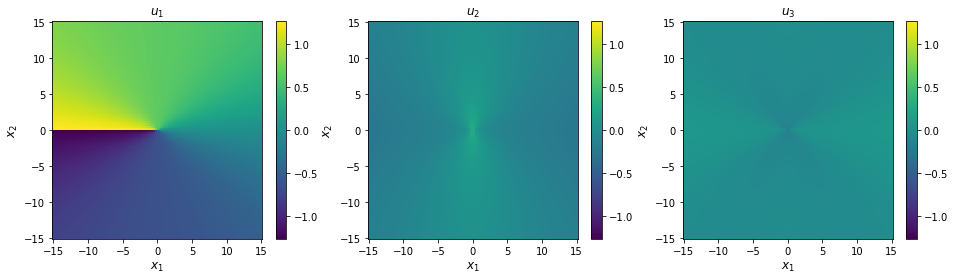

In [10]:
# Compute displacements
disp = solution.displacement(coords)

# Plot
disp_max = np.abs(disp.max())
fig, axes = plt.subplots(figsize=(16,4), ncols=3)

for i in range(3):
    im = axes[i].pcolormesh(xvals, yvals, disp[:,i].reshape(num_xy, num_xy), vmin=-disp_max, vmax=disp_max)
    axes[i].set_title(f'$u_{{{i+1}}}$')
    axes[i].set_xlabel(xlabel, fontsize='large')
    axes[i].set_ylabel(ylabel, fontsize='large')
    fig.colorbar(im, ax=axes[i])

print('Coordinates and displacements in Angstroms')
plt.show()

Stress

Stress components in GPa, coordinates in Angstroms


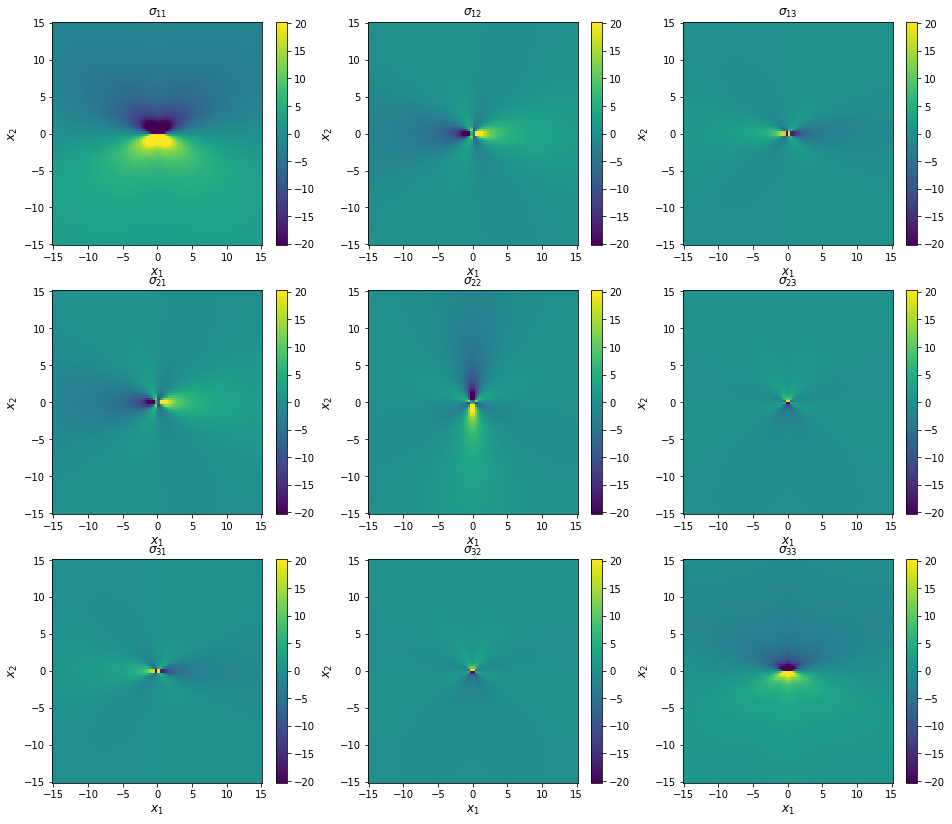

In [11]:
# Compute stress states
stress = uc.get_in_units(solution.stress(coords), 'GPa')

# Plot
stress_max = np.abs(stress.max()) / 10
fig, axes = plt.subplots(figsize=(16,14), ncols=3, nrows=3)

for i in range(3):
    for j in range(3):
        im = axes[i, j].pcolormesh(xvals, yvals, stress[:, i, j].reshape(num_xy, num_xy), vmin=-stress_max, vmax=stress_max)
        axes[i, j].set_title(f'$\sigma_{{{i+1}{j+1}}}$')
        axes[i, j].set_xlabel(xlabel, fontsize='large')
        axes[i, j].set_ylabel(ylabel, fontsize='large')
        fig.colorbar(im, ax=axes[i, j])

print('Stress components in GPa, coordinates in Angstroms')
plt.show()

## 4. Dislocation initialization<a id='section4'></a>

The Dislocation class is initialized by giving it parameters associated with the crystal information and the dislocation definition.

Crystal parameters

- __ucell__ (*atomman.System*) The unit cell to use as the seed for generating the dislocation monopole system.
- __C__ (*atomman.ElasticConstants*) The elastic constants associated with the bulk crystal structure for ucell.

Dislocation parameters

- __burgers__ (*array-like object*) The dislocation's Burgers vector given as a Miller or Miller-Bravais vector relative to ucell.
- __ξ_uvw__ (*array-like object*) The dislocation's line direction given as a Miller or Miller-Bravais vector relative to ucell.
- __slip_hkl__ (*array-like object*) The dislocation's slip plane given as a Miller or Miller-Bravais plane relative to ucell.
- __m__ (*array-like object, optional*) The m unit vector for the dislocation solution.  m, n, and ξ (dislocation line) should be right-hand orthogonal.  Default value is \[0,1,0\] (y-axis).
- __n__ (*array-like object, optional*) The n unit vector for the dislocation solution.  m, n, and ξ (dislocation line) should be right-hand orthogonal.  Default value is \[0,0,1\] (z-axis). n is normal to the dislocation slip plane.
- __tol__ (*float*) A cutoff tolerance used with obtaining the dislocation solution. Only needs to be changed if there are issues with obtaining a solution.

Shift parameters

- __shift__ (*float, optional*) A rigid body shift to apply to the rotated cell prior to inserting the dislocation.  Should be selected such that the ideal slip plane does not correspond to any atomic planes.  Is taken as absolute if shiftscale is False, or relative to the rotated cell's box vectors if shiftscale is True.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given then shiftindex = 0 is used.
- __shiftindex__ (*float, optional*) The index of the identified optimum shifts based on the rotated cell to use.  Different values allow for the selection of different atomic planes neighboring the slip plane.  Note that shiftindex values only apply shifts normal to the slip plane; best shifts for non-planar dislocations (like bcc screw) may also need a shift in the slip plane.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given then shiftindex = 0 is used.
- __shiftscale__ (*bool, optional*) If False (default), a given shift value will be taken as absolute Cartesian.  If True, a given shift will be taken relative to the rotated cell's box vectors.

### 4.1. Define the Dislocation

This is similar to what is done in Section #3 with the main differences being that the full unit cell is created rather than the box, and m and n are left as their default values.  The default m=$[0,1,0]$ and n=$[0,0,1]$ values are left alone as this is the optimal choice for LAMMPS calculations and allows for the construction of any perfect straight dislocation type for any crystal structure.

Specify materials properties, namely the unit cell and the elastic constants.

In [12]:
# Rough values for fcc Al

ucell = am.load('prototype', 'A1--Cu--fcc', a=4.05, symbols='Al')
print(ucell)
print()

C = am.ElasticConstants(C11 = uc.set_in_units(105, 'GPa'),
                        C12 = uc.set_in_units(70, 'GPa'), 
                        C44 = uc.set_in_units(45, 'GPa'))
print('Cij (GPa) =')
print(uc.get_in_units(C.Cij, 'GPa'))

avect =  [ 4.050,  0.000,  0.000]
bvect =  [ 0.000,  4.050,  0.000]
cvect =  [ 0.000,  0.000,  4.050]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Al',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   2.025 |   2.025
      2 |       1 |   2.025 |   0.000 |   2.025
      3 |       1 |   2.025 |   2.025 |   0.000

Cij (GPa) =
[[105.  70.  70.   0.   0.   0.]
 [ 70. 105.  70.   0.   0.   0.]
 [ 70.  70. 105.   0.   0.   0.]
 [  0.   0.   0.  45.   0.   0.]
 [  0.   0.   0.   0.  45.   0.]
 [  0.   0.   0.   0.   0.  45.]]


Define the dislocation 

In [13]:
# FCC a/2<101>{111} dislocation
burgers = np.array([0.5, 0.0, -0.5])
slip_hkl = np.array([1,1,1])

# Line direction determines dislocation character
#ξ_uvw = [ 1,-2, 1] # 90 degree edge
#ξ_uvw = [1, -1, 0] # 60 degree mixed
ξ_uvw = [1, 1, -2] # 30 degree mixed
#ξ_uvw = [1, 0, -1] # 0 degree screw, i.e. parallel to burgers

Initialize the Dislocation object using the above parameters

In [14]:
disl = am.defect.Dislocation(ucell, C, burgers, ξ_uvw, slip_hkl)

### 4.2. Check the solution

The Dislocation object has a number of attributes that describe the basic setup.

- __transform__ is the Cartesian transformation matrix associated with rotating from the unit cell orientation to the rotated cell orientation.  This can be used to transform any other vectors between the two orientations.
- __uvws__ are the Miller vectors relative to the unit cell that are used for the rotated cell's box vectors.
- __ucell__ is the unit cell.
- __rcell__ is the cell obtained after rotating ucell.
- __dislsol__ is the VolterraDislocation solution that will be used to displace the atoms
- __shifts__ provides a list of all "ideal" delta shift values that will position the slip plane halfway between two atomic planes.  There is no guarantee that the planes are symmetrically unique and no shifting in the plane is accounted for either. 
- __shift__ is the shift value currently set.  The default value is the first value in shifts. 

In [15]:
print('Transformation matrix =')
print(disl.transform)
print()

print('Rotation uvws =')
print(disl.uvws)
print()

print('Unit cell =')
print(disl.ucell)
print()

print('Rotated cell =')
print(disl.rcell)
print()

Transformation matrix =
[[ 0.40824829  0.40824829 -0.81649658]
 [-0.70710678  0.70710678  0.        ]
 [ 0.57735027  0.57735027  0.57735027]]

Rotation uvws =
[[ 1.  1. -2.]
 [-1.  1.  0.]
 [ 1.  1.  1.]]

Unit cell =
avect =  [ 4.050,  0.000,  0.000]
bvect =  [ 0.000,  4.050,  0.000]
cvect =  [ 0.000,  0.000,  4.050]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Al',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   2.025 |   2.025
      2 |       1 |   2.025 |   0.000 |   2.025
      3 |       1 |   2.025 |   2.025 |   0.000

Rotated cell =
avect =  [ 9.920,  0.000,  0.000]
bvect =  [ 0.000,  5.728,  0.000]
cvect =  [ 0.000,  0.000,  7.015]
origin = [ 0.000,  0.000,  0.000]
natoms = 24
natypes = 1
symbols = ('Al',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  

A Volterra dislocation solution is also obtained, which is accessible as the dislsol attribute

In [16]:
print(f'character angle = {disl.dislsol.characterangle()} degrees')
print(f'K_coeff = {uc.get_in_units(disl.dislsol.K_coeff, "GPa"):.3f} GPa')
print('burgers =', uc.get_in_units(disl.dislsol.burgers, "angstrom"), 'angstrom')

character angle = 30.000000000000004 degrees
K_coeff = 33.399 GPa
burgers = [ 2.48010836 -1.43189123  0.        ] angstrom


The shift values should be selected such that the dislocation falls between atomic positions. For planar dislocations, the slip plane should be placed roughly halfway between atomic planes.  The class automatically identifies all such shifts relative to rcell and stores them as the attribute shifts.

The initialization parameters allow for shifts to be defined in one of three ways:

1. Giving shiftindex indicates which of the identified shifts relative to rcell to use.  If neither shift or shiftindex is specified, then shiftindex=0 is used.
2. Giving shift with shiftscale=False allows for an absolute Cartesian shift to be specified.
3. Giving shift with shiftscale=True allows for a shift relative to rcell's box vectors to be specified.

For non-planar screw dislocations, the dislocation core should be placed in the proper location where the involved slip planes intercept. This can be handled by specifying shifts using options 2 or 3.

Note that the shift can be changed when calling the monopole and periodicarray methods.

In [17]:
print('Identified shifts =')
print(disl.shifts)
print()

print('The shift currently set to be used =', disl.shift)

Identified shifts =
[[0.         0.         1.1691343 ]
 [0.         0.         3.50740289]
 [0.         0.         5.84567148]]

The shift currently set to be used = [0.        0.        1.1691343]


## 5. Dislocation Monopole Configuration<a id='section5'></a>


System size parameters

- __sizemults__ (*tuple, optional*) The size multipliers to use when generating the system.  Values are limited to being positive integers.  The multipliers for the two non-periodic directions must be even.  If not given, the default multipliers will be 2 for the non-periodic directions and 1 for the periodic direction.
- __amin__ (*float, optional*) A minimum thickness to use for the a box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both amin and sizemults is given, then the larger multiplier for the two will be used.
- __bmin__ (*float, optional*) A minimum thickness to use for the b box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both bmin and sizemults is given, then the larger multiplier for the two will be used.
- __cmin__ (*float, optional*) A minimum thickness to use for the c box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both cmin and sizemults is given, then the larger multiplier for the two will be used.

Shift parameters

- __shift__ (*float, optional*) A rigid body shift to apply to the rotated cell prior to inserting the dislocation.  Should be selected such that the ideal slip plane does not correspond to any atomic planes.  Is taken as absolute if shiftscale is False, or relative to the rotated cell's box vectors if shiftscale is True.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given will use the shift set during class initialization.
- __shiftindex__ (*float, optional*) The index of the identified optimum shifts based on the rotated cell to use.  Different values allow for the selection of different atomic planes neighboring the slip plane.  Note that shiftindex values only apply shifts normal to the slip plane; best shifts for non-planar dislocations (like bcc screw) may also need a shift in the slip plane.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given then shiftindex = 0 is used then will use the shift set during class initialization.
- __shiftscale__ (*bool, optional*) If False (default), a given shift value will be taken as absolute Cartesian.  If True, a given shift will be taken relative to the rotated cell's box vectors.

Boundary parameters

- __boundaryshape__ (*str, optional*) Indicates the shape of the boundary region to use.  Options are 'cylinder' (default) and 'box'.  For 'cylinder', the non-boundary region is defined by a cylinder with axis along the dislocation line and a radius that ensures the boundary is at least boundarywidth thick.  For 'box', the boundary region will be exactly boundarywidth thick all around.      
- __boundarywidth__ (*float, optional*) The width of the boundary region to apply.  Default value is 0.0, i.e. no boundary region.  All atoms in the boundary region will have their atype values changed.
- __boundaryscale__ (*bool, optional*) If False (Default), the boundarywidth will be taken as absolute. If True, the boundarywidth will be taken relative to the magnitude of the unit cell's a box vector.

Return options

- __return_base_system__ (*bool, optional*) If True then the dislocation-free base system corresponding to the dislocation system will also be returned.  The base system is used as a reference state for most of the dislocation analysis tools.

### 5.1. Small atomic system example, easy to see atomic positions

In [18]:
base_system, disl_system = disl.monopole(bmin=30, cmin=30,
                                         boundarywidth=1, boundaryscale=True,
                                         return_base_system=True)

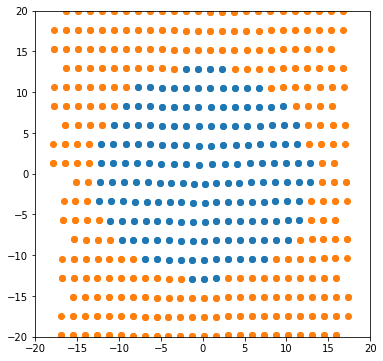

In [19]:
fig = plt.figure(figsize=(6,6))
for atype in disl_system.atypes:
    plt.plot(disl_system.atoms.pos[disl_system.atoms.atype==atype, 1],
             disl_system.atoms.pos[disl_system.atoms.atype==atype, 2], 'o')
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.show()

### 5.2. Large atomic system example, more useful for simulations

In [20]:
base_system, disl_system = disl.monopole(bmin=300, cmin=300,
                                         boundarywidth=1, boundaryscale=True,
                                         return_base_system=True)

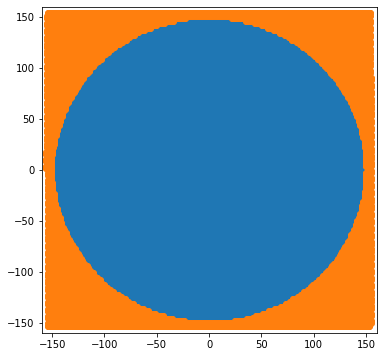

In [21]:
fig = plt.figure(figsize=(6,6))
for atype in disl_system.atypes:
    plt.plot(disl_system.atoms.pos[disl_system.atoms.atype==atype, 1],
             disl_system.atoms.pos[disl_system.atoms.atype==atype, 2], 'o')
plt.xlim(-160, 160)
plt.ylim(-160, 160)
plt.show()

### 5.3. Dislocation property evaluations

The dislocation characterization methods all compare defect configurations to a defect-free base system.  The monopole method automatically returns a compatible base system that can be used for the characterization methods.

See the [4.6. Dislocation analysis tools Notebook](4.6. Dislocation analysis tools.ipynb) for more dislocation property evaluations.

__NOTE__: The characterizations shown here are simply for demonstration purposes. For real problems, the returned dislocation system should be atomically relaxed prior to characterizing it.

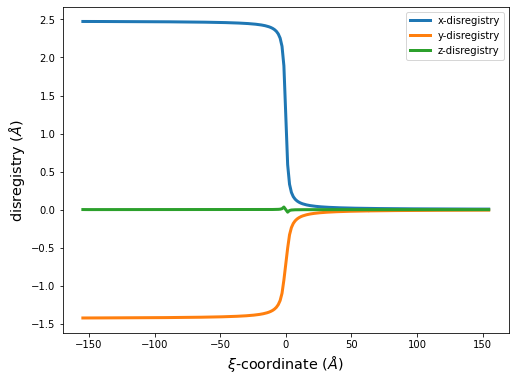

In [22]:
# Plot disregistry
xi, disreg = am.defect.disregistry(base_system, disl_system, m=[0,1,0], n=[0,0,1])

fig = plt.figure(figsize=(8,6))

plt.plot(xi, disreg[:, 0], label='x-disregistry', linewidth=3)
plt.plot(xi, disreg[:, 1], label='y-disregistry', linewidth=3)
plt.plot(xi, disreg[:, 2], label='z-disregistry', linewidth=3)

plt.xlabel('$\\xi$-coordinate ($\AA$)', size='x-large')
plt.ylabel('disregistry ($\AA$)', size='x-large')
plt.legend(fontsize='xx-large')

plt.legend()
plt.show()

## 6. Periodic Array of Dislocations Configuration<a id='section6'></a>

System size parameters

- __sizemults__ (*tuple, optional*) The size multipliers to use when generating the system.  Values are limited to being positive integers.  The multipliers for the two non-periodic directions must be even.  If not given, the default multipliers will be 2 for the non-periodic directions and 1 for the periodic direction.
- __amin__ (*float, optional*) A minimum thickness to use for the a box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both amin and sizemults is given, then the larger multiplier for the two will be used.
- __bmin__ (*float, optional*) A minimum thickness to use for the b box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both bmin and sizemults is given, then the larger multiplier for the two will be used.
- __cmin__ (*float, optional*) A minimum thickness to use for the c box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both cmin and sizemults is given, then the larger multiplier for the two will be used.

Shift parameters

- __shift__ (*float, optional*) A rigid body shift to apply to the rotated cell prior to inserting the dislocation.  Should be selected such that the ideal slip plane does not correspond to any atomic planes.  Is taken as absolute if shiftscale is False, or relative to the rotated cell's box vectors if shiftscale is True.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given then shiftindex = 0 is used.
- __shiftindex__ (*float, optional*) The index of the identified optimum shifts based on the rotated cell to use.  Different values allow for the selection of different atomic planes neighboring the slip plane.  Note that shiftindex values only apply shifts normal to the slip plane; best shifts for non-planar dislocations (like bcc screw) may also need a shift in the slip plane.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given then shiftindex = 0 is used.
- __shiftscale__ (*bool, optional*) If False (default), a given shift value will be taken as absolute Cartesian.  If True, a given shift will be taken relative to the rotated cell's box vectors.

Boundary parameters

- __boundarywidth__ (*float, optional*) The width of the boundary region to apply.  Default value is 0.0, i.e. no boundary region.  All atoms in the boundary region will have their atype values changed and will be displaced by linear displacements.
- __boundaryscale__ (*bool, optional*) If False (Default), the boundarywidth will be taken as absolute. If True, the boundarywidth will be taken relative to the magnitude of the unit cell's a box vector.

Method options

- __linear__ (*bool, optional*) If True, then only linear displacements will be used and not the dislocation solution.  Using only linear displacements is useful for screw dislocations and dislocations with large stacking fault distances.  If False (default) then the dislocation solution will be used for the middle displacements and linear displacements only in the boundary region.
- __cutoff__ (*float, optional*) Cutoff distance to use for identifying duplicate atoms to remove. For dislocations with an edge component, applying the displacements creates an extra half-plane of atoms that will have (nearly) identical positions with other atoms after altering the boundary conditions.  Default value is 0.5 Angstrom.

Return options

- __return_base_system__ (*bool, optional*) If True then the dislocation-free base system corresponding to the dislocation system will also be returned.  The base system is used as a reference state for most of the dislocation analysis tools.

### 6.1. Small atomic system example, easy to see atomic positions

In [23]:
base_system, disl_system = disl.periodicarray(bmin=30, cmin=30,
                                              boundarywidth=3, boundaryscale=True,
                                              return_base_system=True)

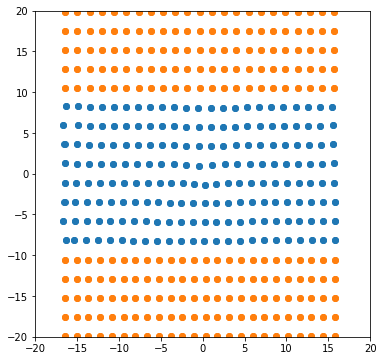

In [24]:
fig = plt.figure(figsize=(6,6))
for atype in disl_system.atypes:
    plt.plot(disl_system.atoms.pos[disl_system.atoms.atype==atype, 1],
             disl_system.atoms.pos[disl_system.atoms.atype==atype, 2], 'o')
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.show()

### 6.2. Large atomic system example, more useful for simulations

In [25]:
base_system, disl_system = disl.periodicarray(bmin=300, cmin=300,
                                              boundarywidth=3, boundaryscale=True,
                                              return_base_system=True)

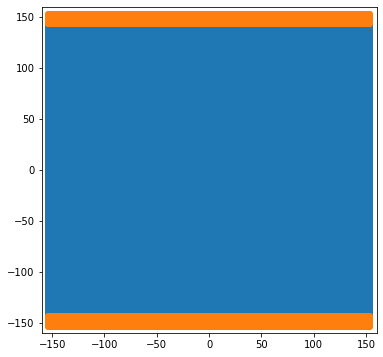

In [26]:
fig = plt.figure(figsize=(6,6))
for atype in disl_system.atypes:
    plt.plot(disl_system.atoms.pos[disl_system.atoms.atype==atype, 1],
             disl_system.atoms.pos[disl_system.atoms.atype==atype, 2], 'o')
plt.xlim(-160, 160)
plt.ylim(-160, 160)
plt.show()

### 6.3. Dislocation property evaluations

The dislocation characterization methods all compare defect configurations to a defect-free base system.  The periodicarray method automatically returns a compatible base system that can be used for the characterization methods.  This is especially important for PAD systems of dislocations with edge components as the deleted atoms are appropriately handled.

See the [4.6. Dislocation analysis tools Notebook](4.6. Dislocation analysis tools.ipynb) for more dislocation property evaluations.

__NOTE__: The characterizations shown here are simply for demonstration purposes. For real problems, the returned dislocation system should be atomically relaxed prior to characterizing it.

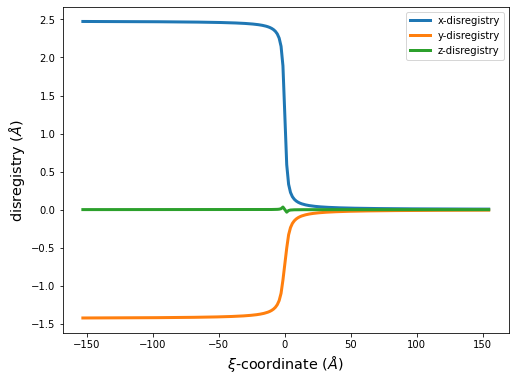

In [27]:
# Plot disregistry
xi, disreg = am.defect.disregistry(base_system, disl_system, m=[0,1,0], n=[0,0,1])

fig = plt.figure(figsize=(8,6))

plt.plot(xi, disreg[:, 0], label='x-disregistry', linewidth=3)
plt.plot(xi, disreg[:, 1], label='y-disregistry', linewidth=3)
plt.plot(xi, disreg[:, 2], label='z-disregistry', linewidth=3)

plt.xlabel('$\\xi$-coordinate ($\AA$)', size='x-large')
plt.ylabel('disregistry ($\AA$)', size='x-large')
plt.legend(fontsize='xx-large')

plt.legend()
plt.show()